In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.1 MB 1.2 MB/s 
     |████████████████████████████████| 8.8 MB 44.6 MB/s 
     |████████████████████████████████| 468 kB 59.7 MB/s 


In [1]:
import os
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import operator
import random
import copy
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD, lr_scheduler
import torch.nn.functional as F
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial


# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

## Data preprocessing

### Encoding categorical features

- I will use one-hot-encoding for ["race/ethnicity", "gender"] features because they are nominal categorical features
- Ordinal encoding for rest of the features as they are ordinal categorical features

In [38]:
def categorical_encoder(df, nominal_ft=None, ordinal_mapper=None):
    if nominal_ft:
        encoder = OneHotEncoder(sparse=False, drop='first')
        encoder.fit(df[nominal_ft])
        new_feats = encoder.transform(df[nominal_ft])
        # create dataframe from encoded features with named columns
        new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names_out(nominal_ft))
        df = pd.concat([df, new_cols], axis=1)    
        df.drop(nominal_ft, axis=1, inplace=True)
    # I use ordinal mapper because I want the ordinal values to be arranged in a sensable order 
    if ordinal_mapper:    
        for key in ordinal_mapper.keys():
            ordinal_data = df[key]
            ordinal_data = np.array(ordinal_data).reshape(-1, 1)
            ordinal_encoder = OrdinalEncoder(categories=[ordinal_mapper[key]])
            ordinal_data = ordinal_encoder.fit_transform(ordinal_data)
            ordinal_df = pd.DataFrame(data=ordinal_data, columns=[key])
            df = df.drop(key, axis=1)
            df = pd.concat([df, ordinal_df], axis=1)
    return df

In [40]:
df = pd.read_csv("/content/drive/MyDrive/ML/Assigment2/Task 1.csv")

In [41]:
nominal_ft = ["race/ethnicity", "gender"]
mapper = {
    'parental level of education': ["some high school", "high school", "associate's degree", "some college", "bachelor's degree", "master's degree"],
    'lunch': ['standard', "free/reduced"],
    'test preparation course': ['none', 'completed']
}
df = categorical_encoder(df, nominal_ft=nominal_ft, ordinal_mapper=mapper)
df


,math score,reading score,writing score,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,gender_male,parental level of education,lunch,test preparation course
0,67,67,63,0,0,0,0,1,1.0,0.0,1.0
1,40,59,55,0,0,1,0,0,0.0,1.0,0.0
2,59,60,50,0,0,0,1,1,3.0,1.0,0.0
3,77,78,68,1,0,0,0,1,1.0,0.0,0.0
4,78,73,68,0,0,0,1,1,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
995,73,70,65,0,1,0,0,1,1.0,0.0,0.0
996,85,91,92,0,0,1,0,1,2.0,1.0,1.0
997,32,35,41,0,1,0,0,0,0.0,1.0,0.0
998,73,74,82,0,1,0,0,0,3.0,0.0,0.0


I used mapper to manually rank the values of some features in order for them to have a meaningful representation

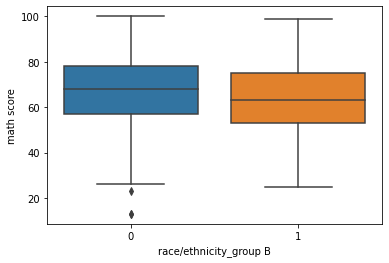

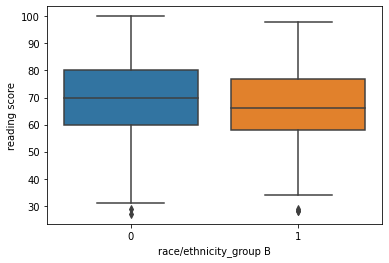

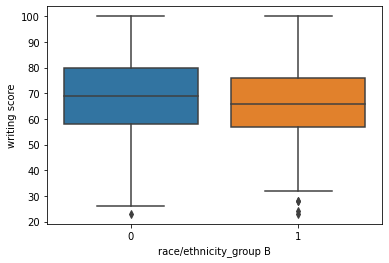

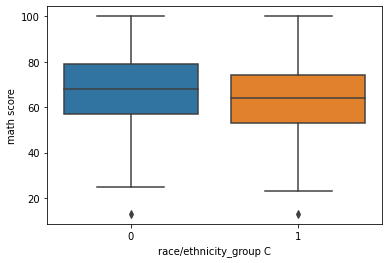

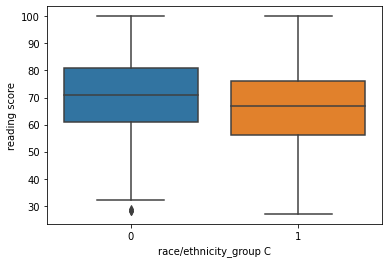

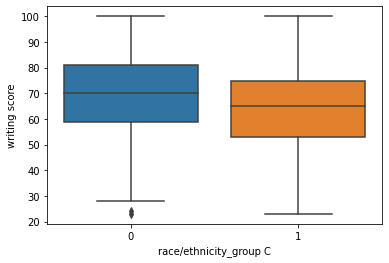

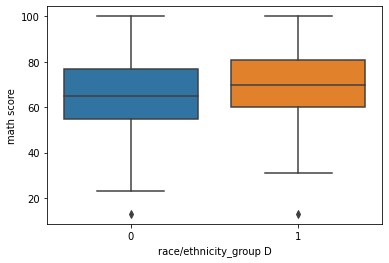

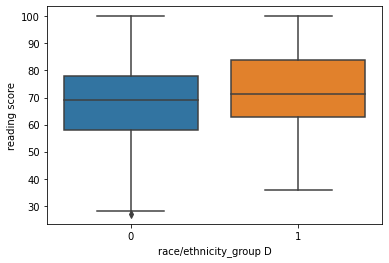

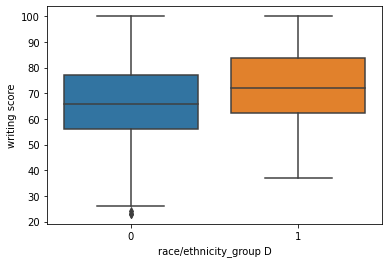

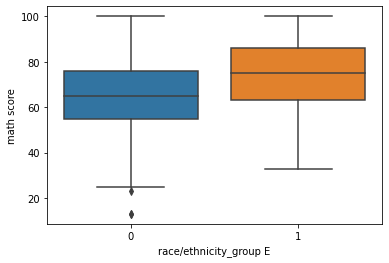

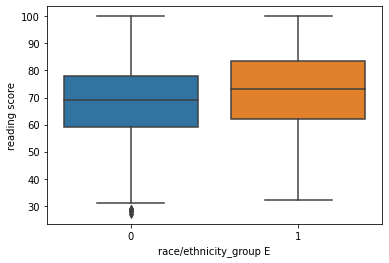

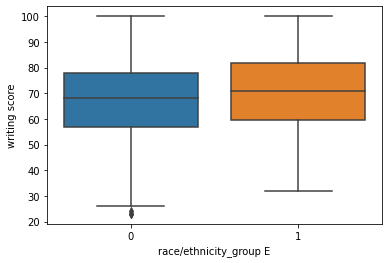

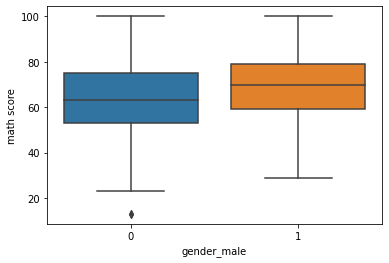

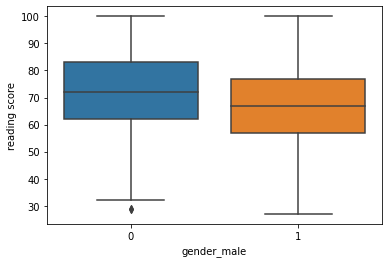

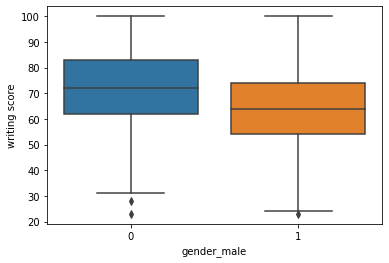

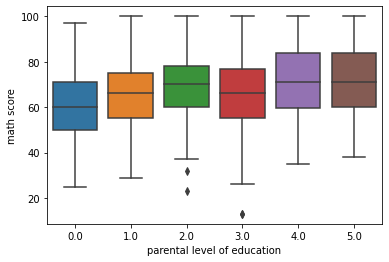

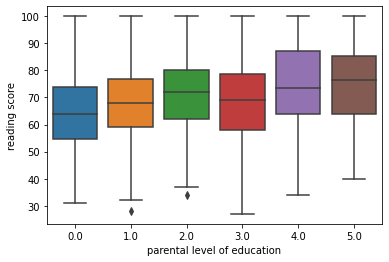

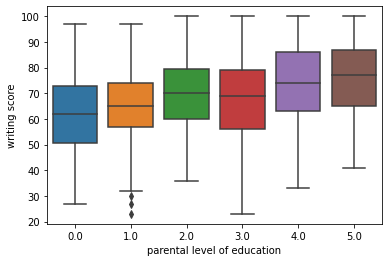

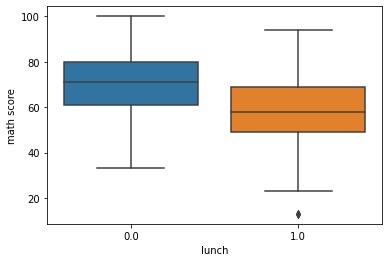

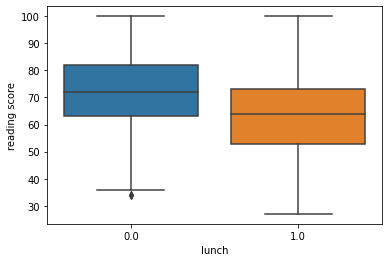

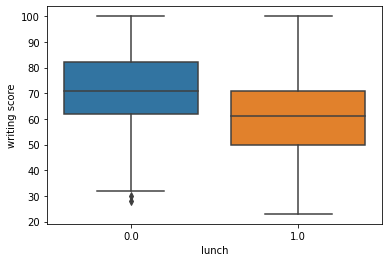

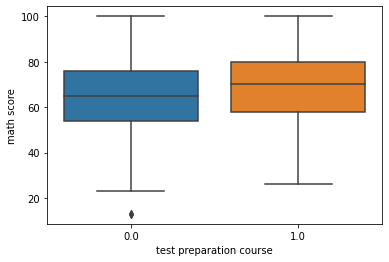

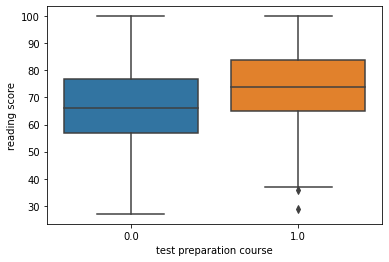

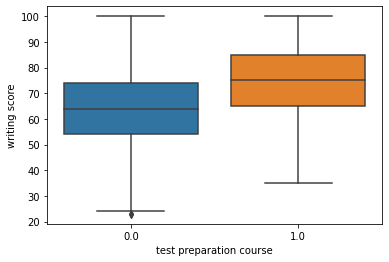

In [ ]:
features = list(df.columns)[3:]
targets = list(df.columns)[0:3]

for x in features:
  for y in targets:
    sns.boxplot(data=df, x=x, y=y)
    plt.show()

From the graphs above, we can notice some interesting results:
- race/ethnicity_group E and D performed better than other groups in all tests
- gende_male performed better in math, while females performing better in reading and writing
- as the parental level of education increases, the student gets a better score
- Students who had standard lunch had higher lower quartile, median, and upper quartile scores in all subjects than students with free lunch
- And of course students who had completed their test preparation had higher overall results than other students


In [42]:
class ScoresDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [43]:
class ANN(nn.Module):
    def __init__(self, input_in_features, n_hidden_layers, hidden_neurons, activation_function, dropout_prob):
        super(ANN, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(in_features=input_in_features, out_features=hidden_neurons),
            activation_function
        )
        hidden_layer = nn.Sequential(
            nn.Linear(in_features=hidden_neurons,out_features=hidden_neurons),
            activation_function
        )
        self.hidden_layers = nn.ModuleList([hidden_layer for i in range(n_hidden_layers)])
        self.dropout = nn.Dropout(dropout_prob)
        self.output_layer = nn.Linear(in_features=hidden_neurons, out_features=3)
    
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.hidden_layers:
          x = layer(x)
          x = self.dropout(x)
        x = self.output_layer(x)
        return x
        

In [44]:
y = ['math score', 'reading score', 'writing score']
X = df.drop(y, axis=1).to_numpy()
y = df[y].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True)

train_data = ScoresDataset(x_train, y_train)
test_data = ScoresDataset(x_test, y_test)


### Hyperparameter tuning

In [48]:
def train_model(config=None, train_data=None, test_data=None, num_epochs=25):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ANN(input_in_features=8,
            n_hidden_layers=config['n_hidden_layers'],
            hidden_neurons=config['hidden_neurons'],
            activation_function=config['activation_function'],
            dropout_prob=config['dropout_prob']
            )
    model.to(device)
    train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True)
    dataset_sizes = {
    'train': len(train_data),
    'val': len(test_data)
    }
    dataloaders = {
        'train': train_loader,
        'val': test_loader
    }
    
    criterion = nn.L1Loss()

    if config['optimizer'] == 'Adam':
      optimizer = Adam(model.parameters(), lr=config['lr'])
    else:
      optimizer = SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'])
    schedular = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)
    
    val_acc_history = []

    # best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000

    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            # print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == 'val':
                val_acc_history.append(epoch_loss)
            if phase == 'train':
                schedular.step(epoch_loss)
    tune.report(loss=best_loss)
    print("Finished Training")

In [49]:
config = {
    "n_hidden_layers": tune.sample_from(lambda _: np.random.randint(1,15)),
    "hidden_neurons": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-5, 1e-1),
    "batch_size": tune.choice([50, 100, 200, 400]),
    "activation_function": tune.choice([nn.ReLU(), nn.LeakyReLU()]),
    "momentum": tune.sample_from(lambda _: np.random.uniform(0,1.0)),
    "optimizer": tune.choice(['Adam', 'SGD']),
    "dropout_prob": tune.sample_from(lambda _: np.random.uniform(0,0.5))
}
reporter = CLIReporter(
    metric_columns=["loss"])
num_epochs = 100
result = tune.run(
    partial(train_model, train_data=train_data, test_data=test_data, num_epochs=num_epochs),
    config=config,
    num_samples=100,
    progress_reporter=reporter
)
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))

2022-11-23 12:31:27,409	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2022-11-23 12:31:29 (running for 00:00:01.69)
Memory usage on this node: 4.5/12.7 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/2 CPUs, 0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-11-23_12-31-27
Number of trials: 16/100 (15 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+-----------------------+--------------+----------------+------------------+-------------+------------+-------------------+-------------+
| Trial name              | status   | loc             | activation_function   |   batch_size |   dropout_prob |   hidden_neurons |          lr |   momentum |   n_hidden_layers | optimizer   |
|-------------------------+----------+-----------------+-----------------------+--------------+----------------+------------------+-------------+------------+-------------------+-------------|
| train_model_c01a1_00000 | RUNNING  | 172.28.0

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_c01a1_00000,2022-11-23_12-31-34,True,,d3a901bd315f4e98a51fc7667c39dc16,"0_activation_function=LeakyReLU_negative_slope_0_01,batch_size=200,dropout_prob=0.0413,hidden_neurons=4,lr=0.0084,momentum=0.6332,n_hidden_layers=12,optimizer=Adam",e9b57f55851e,1,11.8522,172.28.0.2,3736,2.62676,2.62676,2.62676,1669206694,0,,1,c01a1_00000,0.00660968
train_model_c01a1_00001,2022-11-23_12-31-39,True,,1b161493eb3a4d079a57a7b17608897e,"1_activation_function=LeakyReLU_negative_slope_0_01,batch_size=50,dropout_prob=0.0751,hidden_neurons=8,lr=0.0453,momentum=0.0446,n_hidden_layers=1,optimizer=SGD",e9b57f55851e,1,10.796,172.28.0.2,3797,3.25666,3.25666,3.25666,1669206699,0,,1,c01a1_00001,0.00402856
train_model_c01a1_00002,2022-11-23_12-31-43,True,,d3a901bd315f4e98a51fc7667c39dc16,"2_activation_function=LeakyReLU_negative_slope_0_01,batch_size=50,dropout_prob=0.1399,hidden_neurons=256,lr=0.0267,momentum=0.7149,n_hidden_layers=2,optimizer=Adam",e9b57f55851e,1,10.4315,172.28.0.2,3736,7.24433,7.24433,7.24433,1669206703,0,,1,c01a1_00002,0.00660968
train_model_c01a1_00003,2022-11-23_12-31-43,True,,1b161493eb3a4d079a57a7b17608897e,"3_activation_function=ReLU,batch_size=50,dropout_prob=0.4961,hidden_neurons=32,lr=0.0631,momentum=0.4868,n_hidden_layers=2,optimizer=Adam",e9b57f55851e,1,10.8194,172.28.0.2,3797,4.39846,4.39846,4.39846,1669206703,0,,1,c01a1_00003,0.00402856
train_model_c01a1_00004,2022-11-23_12-31-50,True,,d3a901bd315f4e98a51fc7667c39dc16,"4_activation_function=LeakyReLU_negative_slope_0_01,batch_size=50,dropout_prob=0.3984,hidden_neurons=32,lr=0.0001,momentum=0.8566,n_hidden_layers=12,optimizer=SGD",e9b57f55851e,1,67.4438,172.28.0.2,3736,6.70161,6.70161,6.70161,1669206710,0,,1,c01a1_00004,0.00660968
train_model_c01a1_00005,2022-11-23_12-31-46,True,,1b161493eb3a4d079a57a7b17608897e,"5_activation_function=ReLU,batch_size=200,dropout_prob=0.4116,hidden_neurons=4,lr=0.0002,momentum=0.2813,n_hidden_layers=10,optimizer=SGD",e9b57f55851e,1,67.4469,172.28.0.2,3797,2.26057,2.26057,2.26057,1669206706,0,,1,c01a1_00005,0.00402856
train_model_c01a1_00006,2022-11-23_12-31-47,True,,1b161493eb3a4d079a57a7b17608897e,"6_activation_function=LeakyReLU_negative_slope_0_01,batch_size=400,dropout_prob=0.1248,hidden_neurons=32,lr=0.0013,momentum=0.3136,n_hidden_layers=1,optimizer=SGD",e9b57f55851e,1,67.0623,172.28.0.2,3797,1.29124,1.29124,1.29124,1669206707,0,,1,c01a1_00006,0.00402856
train_model_c01a1_00007,2022-11-23_12-31-48,True,,1b161493eb3a4d079a57a7b17608897e,"7_activation_function=ReLU,batch_size=400,dropout_prob=0.1292,hidden_neurons=16,lr=0.0018,momentum=0.3650,n_hidden_layers=2,optimizer=SGD",e9b57f55851e,1,67.3283,172.28.0.2,3797,1.18456,1.18456,1.18456,1669206708,0,,1,c01a1_00007,0.00402856
train_model_c01a1_00008,2022-11-23_12-31-50,True,,1b161493eb3a4d079a57a7b17608897e,"8_activation_function=ReLU,batch_size=400,dropout_prob=0.2444,hidden_neurons=16,lr=0.0006,momentum=0.0863,n_hidden_layers=7,optimizer=Adam",e9b57f55851e,1,18.1658,172.28.0.2,3797,1.72209,1.72209,1.72209,1669206710,0,,1,c01a1_00008,0.00402856
train_model_c01a1_00009,2022-11-23_12-31-52,True,,d3a901bd315f4e98a51fc7667c39dc16,"9_activation_function=LeakyReLU_negative_slope_0_01,batch_size=200,dropout_prob=0.4042,hidden_neurons=32,lr=0.0072,momentum=0.7606,n_hidden_layers=8,optimizer=SGD",e9b57f55851e,1,62.8461,172.28.0.2,3736,2.2773,2.2773,2.2773,1669206712,0,,1,c01a1_00009,0.00660968


(func pid=3736) Finished Training
== Status ==
Current time: 2022-11-23 12:31:34 (running for 00:00:07.54)
Memory usage on this node: 4.6/12.7 GiB 
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2022-11-23_12-31-27
Number of trials: 18/100 (16 PENDING, 2 RUNNING)
+-------------------------+----------+-----------------+-----------------------+--------------+----------------+------------------+-------------+------------+-------------------+-------------+---------+
| Trial name              | status   | loc             | activation_function   |   batch_size |   dropout_prob |   hidden_neurons |          lr |   momentum |   n_hidden_layers | optimizer   |    loss |
|-------------------------+----------+-----------------+-----------------------+--------------+----------------+------------------+-------------+------------+-------------------+--------

2022-11-23 12:35:40,191	INFO tune.py:778 -- Total run time: 252.80 seconds (252.50 seconds for the tuning loop).


Best trial config: {'n_hidden_layers': 2, 'hidden_neurons': 256, 'lr': 0.026673631654412944, 'batch_size': 50, 'activation_function': LeakyReLU(negative_slope=0.01), 'momentum': 0.7149398019438994, 'optimizer': 'Adam', 'dropout_prob': 0.13989332387564218}
Best trial final validation loss: 10.431482076644897


### Questions
1. What preprocessing techniques did you use? Why?
    - I encoded the categorical data. I used one-hot-encoding for nominal features which are ["race/ethnicity", "gender"], and ordinal encoding for the ordinal features which are ['parental level of education, 'lunch', 'test preparation course']. Since ANN doesn't take categorical features as input we have to encode these data.
2. Describe the fine-tuning process and how you reached your model architecture.
    - To fine-tune my model, I used a library called ray. I specified some hyperparameters and trained the model with 100 samples from the given parameter space and evaluated it on the test set. The hyperparameters that I tried to tune were:

      - "n_hidden_layers": number of hidden layers in the model
      - "hidden_neurons": number of features in each hidden layers
      - "LR": learning rate
      - "batch_size": batch size for the train and test datasets loaders
      - "activation_function": choosing between ReLU and LeakyReLU activation functions
      - "momentum": choosing the momentum for the SGD optimizer
      - "optimizer": choosing between 2 optimizers Adam, and SGD
      - "dropout_prob": specifying the dropout probability for the dropout layer

    - After making 100 trials, I reached the conclusion that the best performing model has the following hyperparameters:
    
      - 'n_hidden_layers': 2 
      - 'hidden_neurons': 256 
      - 'LR': 0.026673631654412944 
      - 'batch_size': 50, 
      - 'activation_function': LeakyReLU(negative_slope=0.01) 
      - 'optimizer': 'Adam' 
      - 'dropout_prob': 0.13989332387564218
      
    - This model gave MAE of 10.43 for prediction 3 target values from the test set

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

### Handling the data

In [5]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/ML/Assigment2/triple_mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [2]:
class MnistDataset(Dataset):
  def __init__(self, images_dir, transform=None):
    self.images_dir = images_dir
    self.transform = transform
    self.X = []
    self.y = []
    for folder in os.listdir(self.images_dir):
      for img_path in os.listdir(f'{self.images_dir}/{folder}'):
        image = cv2.imread(f'{self.images_dir}/{folder}/{img_path}')
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        t = transforms.ToTensor()
        image = t(image)
        self.X.append(image)
        self.y.append(folder)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]

    if self.transform:
      image = self.transform(image)
    return image, label


In [3]:
train_path = r'D:\University\Third year\ML\Assignment 2\triple_mnist\train'
val_path = r'D:\University\Third year\ML\Assignment 2\triple_mnist\val'
test_path = r'D:\University\Third year\ML\Assignment 2\triple_mnist\test'

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.Normalize((0.5), (0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_data = MnistDataset(train_path, train_transforms)
val_data = MnistDataset(val_path, test_transforms)
test_data = MnistDataset(test_path, test_transforms)

### Train and test code

In [4]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf

        self.operation = operator.gt if mode == 'min' else operator.lt

    def __call__(self, metric):
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter +=1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

In [5]:
def plot_graphs(ys):
  labels = ['train_loss', 'train_acc', 'val_loss', 'val_acc']
  for n, y in enumerate(ys):
    x = [i for i in range(len(y))]
    ax = plt.subplot(3, 2, n+1)
    ax.plot(x, y)
    ax.set_xlabel('epochs')
    ax.set_ylabel(f'{labels[n]}')
  plt.show()



In [6]:
def from_str_to_tensor(labels):
    result = []
    for label in labels:
        n0 = int(label[0])
        n1 = int(label[1])
        n2 = int(label[2])
        result.append([n0, n1, n2])
    result = torch.tensor(result)
    return result

In [7]:
def train_model(config=None, model='ANN', train_data=None, test_data=None, num_epochs=25, with_plot_graphs=False, with_early_stop=True):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if model == 'ANN':
      model = ANN(input_in_features=84*84,
              n_hidden_layers=config['n_hidden_layers'],
              hidden_neurons=config['hidden_neurons'],
              activation_function=config['activation_function'],
              dropout_prob=config['dropout_prob']
              )
    else:
      model = CNN(config['input_out_channel'],
                  config['input_filter'], 
                  config['n_hidden_layers'], 
                  config['hidden_out_channel'], 
                  config['hidden_filter'],
                  config['dropout_prob']
                  )
    model.to(device)
    train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=50, shuffle=True)
    dataset_sizes = {
    'train': len(train_data),
    'val': len(test_data)
    }
    dataloaders = {
        'train': train_loader,
        'val': test_loader
    }
    
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(tolerance=5, mode='min')

    if config['optimizer'] == 'Adam':
      optimizer = Adam(model.parameters(), lr=config['lr'])
    else:
      optimizer = SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'])
    schedular = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_loss = float('inf')
    best_acc = 0
    stop = False
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        if stop:
          break
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = from_str_to_tensor(labels)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = 0
                    for i in range(3):
                        loss += criterion(outputs[i], labels[:, i])
                        
                        _, preds = torch.max(outputs[i], 1)
                        running_corrects += torch.sum(preds == labels[:, i])
                    loss = loss / 10
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / (dataset_sizes[phase]*3)
            print('{} epoch {} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch, epoch_loss, epoch_acc))
            print()
            if phase == 'val':
              val_loss_history.append(epoch_loss)
              val_acc_history.append(epoch_acc.cpu().numpy())
            else:
              train_loss_history.append(epoch_loss)
              train_acc_history.append(epoch_acc.cpu().numpy())

            # deep copy the model
            if phase == 'val' and with_early_stop:
              if early_stopping(epoch_loss):
                print('\nEarly stopping\n')
                stop = True
                break
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
            if phase == 'train':
                schedular.step(epoch_loss)
    if with_plot_graphs:
      plot_graphs([train_loss_history, train_acc_history, val_loss_history, val_acc_history])
    print(f'Best acc on val: {best_acc}')
    print(f'Best loss on val: {best_loss}')
    print("Finished Training")
    return model, best_loss, best_acc 

In [19]:
def testing(model, test_data):
  test_loader = DataLoader(test_data, batch_size=100, shuffle=True)
  with torch.no_grad():
    model.eval()
    running_corrects = 0
    for (x, y) in test_loader:
        x = x.to('cuda')
        y = from_str_to_tensor(y)
        y = y.to('cuda')
        x = x.float()
        pred = model(x)
        for i in range(3):
            _, preds = torch.max(pred[i], 1)
            running_corrects += torch.sum(preds == y[:, i])
    acc = running_corrects.double() / (len(test_data)*3)
    print(f'This model achived {acc} accuracy on the testing set')

In [9]:
import time
def inferance_testing(model, test_data, device):
  test_loader = DataLoader(test_data, batch_size=50, shuffle=True)
  since = time.time()
  with torch.no_grad():
    model.eval()
    running_corrects = 0
    for (x, y) in test_loader:
        x = x.to(device)
        y = from_str_to_tensor(y)
        y = y.to(device)
        x = x.float()
        pred = model(x)
        for i in range(3):
            _, preds = torch.max(pred[i], 1)
            running_corrects += torch.sum(preds == y[:, i])
        break
    acc = running_corrects.double() / (len(test_data)*3)
  time_elapsed = time.time() - since
  return time_elapsed



In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Adapting my best model from task 1

In [31]:
class ANN(nn.Module):
    def __init__(self, input_in_features, n_hidden_layers, hidden_neurons, activation_function, dropout_prob):
        super(ANN, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(in_features=input_in_features, out_features=hidden_neurons),
            activation_function
        )
        hidden_layer = nn.Sequential(
            nn.Linear(in_features=hidden_neurons,out_features=hidden_neurons),
            activation_function
        )
        self.hidden_layers = nn.ModuleList([hidden_layer for i in range(n_hidden_layers)])
        self.dropout = nn.Dropout(dropout_prob)
        self.output_layer = nn.Linear(in_features=hidden_neurons, out_features=30)
    
    def forward(self, x):
        x = x.view(-1, 84*84)
        x = self.input_layer(x)
        for layer in self.hidden_layers:
          x = layer(x)
          x = self.dropout(x)
        x = self.output_layer(x)
        n1 = x[:, :10]
        n2 = x[:, 10:20]
        n3 = x[:, 20:30]
        return [n1, n2, n3]

Epoch 0/99
train epoch 0 Loss: 2.1503 Acc: 0.1076

val epoch 0 Loss: 0.8526 Acc: 0.1228

Epoch 1/99
train epoch 1 Loss: 3.0411 Acc: 0.1061

val epoch 1 Loss: 1.3254 Acc: 0.1107

Epoch 2/99
train epoch 2 Loss: 3.0263 Acc: 0.1053

val epoch 2 Loss: 2.1916 Acc: 0.1068

Epoch 3/99
train epoch 3 Loss: 7.2829 Acc: 0.1039

val epoch 3 Loss: 2.9086 Acc: 0.1134

Epoch 4/99
train epoch 4 Loss: 5.6656 Acc: 0.1081

val epoch 4 Loss: 2.0301 Acc: 0.1156

Epoch 5/99
train epoch 5 Loss: 6.4592 Acc: 0.1065

val epoch 5 Loss: 6.1048 Acc: 0.0837

Epoch 6/99
train epoch 6 Loss: 4.4925 Acc: 0.1087

val epoch 6 Loss: 1.7378 Acc: 0.1168

Epoch 7/99
train epoch 7 Loss: 7.7430 Acc: 0.1074

val epoch 7 Loss: 2.3774 Acc: 0.0954

Epoch 8/99
train epoch 8 Loss: 4.5467 Acc: 0.1105

val epoch 8 Loss: 6.4036 Acc: 0.1132

Epoch 9/99
train epoch 9 Loss: 6.7643 Acc: 0.1072

val epoch 9 Loss: 2.3315 Acc: 0.0967

Epoch 10/99
train epoch 10 Loss: 6.3071 Acc: 0.1093

val epoch 10 Loss: 3.9585 Acc: 0.1028

Epoch 11/99
train 

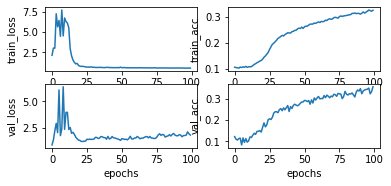

Best acc on val: 0.35783333333333334
Best loss on val: 0.8526212209835649
Finished Training


In [60]:
config = {
    'n_hidden_layers': 2,
    'hidden_neurons': 256, 
    'lr': 0.026673631654412944, 
    'batch_size': 50, 
    'activation_function': nn.LeakyReLU(negative_slope=0.01), 
    'momentum': 0.7149398019438994, 
    'optimizer': 'Adam', 
    'dropout_prob': 0.13989332387564218}

model = train_model(config=config, model='ANN', train_data=train_data, test_data=val_data, num_epochs=100, with_plot_graphs=True, with_early_stop=False)


In [62]:
testing(model[0], test_data)

This model achived 0.34055 accuracy on the testing set


In [66]:
print(count_parameters(model[0]))

1880094


In [68]:
PATH = '/content/drive/MyDrive/ML/Assigment2/ANN_Model.pt'
torch.save(model[0], PATH)

In [32]:
PATH = '/content/drive/MyDrive/ML/Assigment2/ANN_Model.pt'
model = torch.load(PATH, map_location=torch.device('cpu'))

In [34]:
print(inferance_testing(model, test_data, 'cpu'))

0.0340723991394043


As we can see our model achived 34% accuracy on the dataset of the second task.

### Building the CNN model

In [12]:
class CNN(nn.Module):
    def __init__(self,input_out_channel, input_filter, n_hidden_layers, hidden_out_channel, hidden_filter, dropout_prob):
        super().__init__()
        self.conv1 = nn.Conv2d(1, input_out_channel, input_filter)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1_bn = nn.BatchNorm2d(input_out_channel)

        self.first_hidden_layer = nn.Sequential(
            nn.Conv2d(input_out_channel, hidden_out_channel, hidden_filter),
            nn.LazyBatchNorm2d()
        )
        conv_layer = nn.Sequential(
            nn.Conv2d(hidden_out_channel, hidden_out_channel, hidden_filter),
            nn.LazyBatchNorm2d()
        )
        self.hidden_layers = nn.ModuleList([conv_layer for i in range(n_hidden_layers)])

        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 30)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)

        x = F.relu(self.first_hidden_layer(x))
        for layer in self.hidden_layers:
          x = F.relu(layer(x))
          x = self.dropout(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)
        
        n1 = x[:, :10]
        n2 = x[:, 10:20]
        n3 = x[:, 20:30]
        return [n1, n2, n3]

## Hyperparamter tuning

Note that I will use the test set as the train set to make the process faster, then I will train the best preforming model on the whole dataset and report the results on the test dataset

In [ ]:
sample_space = {
    "input_out_channel": [64, 128, 256],
    "input_filter": [3, 5],
    "n_hidden_layers": [i for i in range(1,6)],
    "hidden_out_channel": [64, 128, 256],
    "hidden_filter": [3, 5],
    "lr": [0.002, 0.0002],
    "activation_function": [nn.ReLU(), nn.LeakyReLU()],
    "momentum": np.random.uniform(0,1.0, 3),
    "optimizer": ['Adam', 'SGD'],
    "dropout_prob": np.random.uniform(0, 0.5, 3)
}
num_epochs = 20
num_samples = 10
experiments = {s: [] for s in sample_space.keys()}
experiments['best_loss'] = []
experiments['best_acc'] = []
for i in range(num_samples):
  config = {}
  for parameter in sample_space.keys():
    config[parameter] = random.choice(sample_space[parameter])
    experiments[parameter].append(config[parameter])
  print(config)
  model, best_loss, best_acc = train_model(config=config, model='CNN', train_data=test_data, test_data=val_data, num_epochs=num_epochs)
  experiments['best_loss'].append(best_loss)
  experiments['best_acc'].append(best_acc.cpu().numpy())
  df = pd.DataFrame(experiments)
  print(df)

df


{'input_out_channel': 128, 'input_filter': 3, 'n_hidden_layers': 1, 'hidden_out_channel': 64, 'hidden_filter': 3, 'lr': 0.002, 'activation_function': LeakyReLU(negative_slope=0.01), 'momentum': 0.20556922153851387, 'optimizer': 'Adam', 'dropout_prob': 0.03087446878174316}


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.7001 Acc: 0.1284
val epoch 0 Loss: 0.6993 Acc: 0.0938
train epoch 1 Loss: 0.6850 Acc: 0.1349
val epoch 1 Loss: 0.6994 Acc: 0.0938
train epoch 2 Loss: 0.6850 Acc: 0.1343
val epoch 2 Loss: 0.6998 Acc: 0.0938
train epoch 3 Loss: 0.6850 Acc: 0.1341
val epoch 3 Loss: 0.6990 Acc: 0.0938
train epoch 4 Loss: 0.6850 Acc: 0.1342
val epoch 4 Loss: 0.6997 Acc: 0.0938
train epoch 5 Loss: 0.6850 Acc: 0.1347
val epoch 5 Loss: 0.6989 Acc: 0.0938
train epoch 6 Loss: 0.6850 Acc: 0.1344
val epoch 6 Loss: 0.6994 Acc: 0.0938
train epoch 7 Loss: 0.6850 Acc: 0.1349
val epoch 7 Loss: 0.6995 Acc: 0.0938
train epoch 8 Loss: 0.6850 Acc: 0.1345
val epoch 8 Loss: 0.6990 Acc: 0.0938
train epoch 9 Loss: 0.6850 Acc: 0.1341
val epoch 9 Loss: 0.6985 Acc: 0.0938
train epoch 10 Loss: 0.6849 Acc: 0.1344
val epoch 10 Loss: 0.6995 Acc: 0.0938
train epoch 11 Loss: 0.6849 Acc: 0.1347
val epoch 11 Loss: 0.6991 Acc: 0.0938
train epoch 12 Loss: 0.6849 Acc: 0.1347
val epoch 12 Loss: 0.6994 Acc: 0.0938
train 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.6928 Acc: 0.0980
val epoch 0 Loss: 0.6933 Acc: 0.1075
train epoch 1 Loss: 0.6915 Acc: 0.1030
val epoch 1 Loss: 0.6931 Acc: 0.1064
train epoch 2 Loss: 0.6905 Acc: 0.1083
val epoch 2 Loss: 0.6927 Acc: 0.1069
train epoch 3 Loss: 0.6897 Acc: 0.1123
val epoch 3 Loss: 0.6924 Acc: 0.1027
train epoch 4 Loss: 0.6890 Acc: 0.1161
val epoch 4 Loss: 0.6920 Acc: 0.1016
train epoch 5 Loss: 0.6882 Acc: 0.1176
val epoch 5 Loss: 0.6915 Acc: 0.0997
train epoch 6 Loss: 0.6873 Acc: 0.1185
val epoch 6 Loss: 0.6910 Acc: 0.0995
train epoch 7 Loss: 0.6866 Acc: 0.1219
val epoch 7 Loss: 0.6903 Acc: 0.1005
train epoch 8 Loss: 0.6855 Acc: 0.1241
val epoch 8 Loss: 0.6896 Acc: 0.1001
train epoch 9 Loss: 0.6844 Acc: 0.1257
val epoch 9 Loss: 0.6886 Acc: 0.1036
train epoch 10 Loss: 0.6832 Acc: 0.1298
val epoch 10 Loss: 0.6876 Acc: 0.1085
train epoch 11 Loss: 0.6816 Acc: 0.1350
val epoch 11 Loss: 0.6863 Acc: 0.1127
train epoch 12 Loss: 0.6799 Acc: 0.1408
val epoch 12 Loss: 0.6850 Acc: 0.1209
train 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.7526 Acc: 0.1289
val epoch 0 Loss: 0.6963 Acc: 0.0943
train epoch 1 Loss: 0.6854 Acc: 0.1354
val epoch 1 Loss: 0.6990 Acc: 0.0938
train epoch 2 Loss: 0.6852 Acc: 0.1356
val epoch 2 Loss: 0.6995 Acc: 0.0938
train epoch 3 Loss: 0.6850 Acc: 0.1350
val epoch 3 Loss: 0.6994 Acc: 0.0938
train epoch 4 Loss: 0.6849 Acc: 0.1345
val epoch 4 Loss: 0.6994 Acc: 0.0938
train epoch 5 Loss: 0.6850 Acc: 0.1349
val epoch 5 Loss: 0.6996 Acc: 0.0938

Early stopping

Best acc on val: 0.09433333333333332
Best loss on val: 0.6963102215901017
Finished Training
   input_out_channel  input_filter  n_hidden_layers  hidden_out_channel  \
0                128             3                1                  64   
1                256             3                4                 256   
2                 64             5                1                 256   

   hidden_filter      lr             activation_function  momentum optimizer  \
0              3  0.0020  LeakyReLU(negative_slope=0.0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.7048 Acc: 0.1283
val epoch 0 Loss: 0.6985 Acc: 0.0938
train epoch 1 Loss: 0.6851 Acc: 0.1340
val epoch 1 Loss: 0.6989 Acc: 0.0938
train epoch 2 Loss: 0.6850 Acc: 0.1353
val epoch 2 Loss: 0.6982 Acc: 0.0938
train epoch 3 Loss: 0.6850 Acc: 0.1343
val epoch 3 Loss: 0.6990 Acc: 0.0938
train epoch 4 Loss: 0.6849 Acc: 0.1342
val epoch 4 Loss: 0.6997 Acc: 0.0938
train epoch 5 Loss: 0.6849 Acc: 0.1349
val epoch 5 Loss: 0.6993 Acc: 0.0938
train epoch 6 Loss: 0.6849 Acc: 0.1348
val epoch 6 Loss: 0.6988 Acc: 0.0938
train epoch 7 Loss: 0.6849 Acc: 0.1350
val epoch 7 Loss: 0.6990 Acc: 0.0938

Early stopping

Best acc on val: 0.09375
Best loss on val: 0.6982054758816958
Finished Training
   input_out_channel  input_filter  n_hidden_layers  hidden_out_channel  \
0                128             3                1                  64   
1                256             3                4                 256   
2                 64             5                1                 25

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.6907 Acc: 0.0948
val epoch 0 Loss: 0.6923 Acc: 0.1060
train epoch 1 Loss: 0.6900 Acc: 0.1003
val epoch 1 Loss: 0.6922 Acc: 0.1098
train epoch 2 Loss: 0.6895 Acc: 0.1034
val epoch 2 Loss: 0.6921 Acc: 0.1126
train epoch 3 Loss: 0.6893 Acc: 0.1073
val epoch 3 Loss: 0.6920 Acc: 0.1157
train epoch 4 Loss: 0.6891 Acc: 0.1111
val epoch 4 Loss: 0.6919 Acc: 0.1164
train epoch 5 Loss: 0.6888 Acc: 0.1154
val epoch 5 Loss: 0.6918 Acc: 0.1172
train epoch 6 Loss: 0.6886 Acc: 0.1186
val epoch 6 Loss: 0.6918 Acc: 0.1174
train epoch 7 Loss: 0.6883 Acc: 0.1208
val epoch 7 Loss: 0.6917 Acc: 0.1176
train epoch 8 Loss: 0.6879 Acc: 0.1246
val epoch 8 Loss: 0.6915 Acc: 0.1194
train epoch 9 Loss: 0.6875 Acc: 0.1272
val epoch 9 Loss: 0.6913 Acc: 0.1204
train epoch 10 Loss: 0.6873 Acc: 0.1310
val epoch 10 Loss: 0.6911 Acc: 0.1224
train epoch 11 Loss: 0.6869 Acc: 0.1338
val epoch 11 Loss: 0.6908 Acc: 0.1236
train epoch 12 Loss: 0.6864 Acc: 0.1368
val epoch 12 Loss: 0.6905 Acc: 0.1268
train 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.5778 Acc: 0.3048
val epoch 0 Loss: 0.5138 Acc: 0.3814
train epoch 1 Loss: 0.4013 Acc: 0.5249
val epoch 1 Loss: 0.4360 Acc: 0.4787
train epoch 2 Loss: 0.3325 Acc: 0.6195
val epoch 2 Loss: 0.4048 Acc: 0.5264
train epoch 3 Loss: 0.2953 Acc: 0.6686
val epoch 3 Loss: 0.4016 Acc: 0.5320
train epoch 4 Loss: 0.2639 Acc: 0.7102
val epoch 4 Loss: 0.3691 Acc: 0.5673
train epoch 5 Loss: 0.2472 Acc: 0.7351
val epoch 5 Loss: 0.3747 Acc: 0.5723
train epoch 6 Loss: 0.2293 Acc: 0.7566
val epoch 6 Loss: 0.3653 Acc: 0.5847
train epoch 7 Loss: 0.2199 Acc: 0.7708
val epoch 7 Loss: 0.3632 Acc: 0.5818
train epoch 8 Loss: 0.2076 Acc: 0.7878
val epoch 8 Loss: 0.3521 Acc: 0.5964
train epoch 9 Loss: 0.1966 Acc: 0.7993
val epoch 9 Loss: 0.3570 Acc: 0.6032
train epoch 10 Loss: 0.1912 Acc: 0.8083
val epoch 10 Loss: 0.3682 Acc: 0.5926
train epoch 11 Loss: 0.1867 Acc: 0.8165
val epoch 11 Loss: 0.3564 Acc: 0.6041
train epoch 12 Loss: 0.1807 Acc: 0.8256
val epoch 12 Loss: 0.3498 Acc: 0.6074
train 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.6909 Acc: 0.1165
val epoch 0 Loss: 0.6932 Acc: 0.1043
train epoch 1 Loss: 0.6884 Acc: 0.1363
val epoch 1 Loss: 0.6917 Acc: 0.1344
train epoch 2 Loss: 0.6848 Acc: 0.1547
val epoch 2 Loss: 0.6878 Acc: 0.1528
train epoch 3 Loss: 0.6780 Acc: 0.1804
val epoch 3 Loss: 0.6801 Acc: 0.1820
train epoch 4 Loss: 0.6639 Acc: 0.2203
val epoch 4 Loss: 0.6654 Acc: 0.2316
train epoch 5 Loss: 0.6373 Acc: 0.2800
val epoch 5 Loss: 0.6414 Acc: 0.2777
train epoch 6 Loss: 0.5976 Acc: 0.3420
val epoch 6 Loss: 0.6061 Acc: 0.3251
train epoch 7 Loss: 0.5460 Acc: 0.4112
val epoch 7 Loss: 0.5647 Acc: 0.3729
train epoch 8 Loss: 0.4858 Acc: 0.4826
val epoch 8 Loss: 0.5214 Acc: 0.4104
train epoch 9 Loss: 0.4257 Acc: 0.5432
val epoch 9 Loss: 0.4822 Acc: 0.4516
train epoch 10 Loss: 0.3708 Acc: 0.6006
val epoch 10 Loss: 0.4521 Acc: 0.4847
train epoch 11 Loss: 0.3217 Acc: 0.6521
val epoch 11 Loss: 0.4330 Acc: 0.4962
train epoch 12 Loss: 0.2798 Acc: 0.6993
val epoch 12 Loss: 0.3920 Acc: 0.5561
train 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.6919 Acc: 0.1036
val epoch 0 Loss: 0.6906 Acc: 0.1181
train epoch 1 Loss: 0.6912 Acc: 0.1036
val epoch 1 Loss: 0.6906 Acc: 0.1167
train epoch 2 Loss: 0.6907 Acc: 0.1063
val epoch 2 Loss: 0.6907 Acc: 0.1159
train epoch 3 Loss: 0.6907 Acc: 0.1076
val epoch 3 Loss: 0.6906 Acc: 0.1179
train epoch 4 Loss: 0.6901 Acc: 0.1117
val epoch 4 Loss: 0.6906 Acc: 0.1174
train epoch 5 Loss: 0.6900 Acc: 0.1109
val epoch 5 Loss: 0.6906 Acc: 0.1178

Early stopping

Best acc on val: 0.118125
Best loss on val: 0.6905549932271242
Finished Training
   input_out_channel  input_filter  n_hidden_layers  hidden_out_channel  \
0                128             3                1                  64   
1                256             3                4                 256   
2                 64             5                1                 256   
3                256             5                3                 128   
4                256             5                2                  64

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.6460 Acc: 0.2456
val epoch 0 Loss: 0.5661 Acc: 0.2896
train epoch 1 Loss: 0.3733 Acc: 0.5488
val epoch 1 Loss: 0.3205 Acc: 0.5918
train epoch 2 Loss: 0.2667 Acc: 0.7037
val epoch 2 Loss: 0.3976 Acc: 0.4972
train epoch 3 Loss: 0.2199 Acc: 0.7680
val epoch 3 Loss: 0.2756 Acc: 0.6737
train epoch 4 Loss: 0.1829 Acc: 0.8134
val epoch 4 Loss: 0.3209 Acc: 0.6412
train epoch 5 Loss: 0.1584 Acc: 0.8407
val epoch 5 Loss: 0.2038 Acc: 0.7661
train epoch 6 Loss: 0.1432 Acc: 0.8578
val epoch 6 Loss: 0.2205 Acc: 0.7510
train epoch 7 Loss: 0.1289 Acc: 0.8753
val epoch 7 Loss: 0.2470 Acc: 0.7257
train epoch 8 Loss: 0.1201 Acc: 0.8840
val epoch 8 Loss: 0.2112 Acc: 0.7655
train epoch 9 Loss: 0.1091 Acc: 0.8960
val epoch 9 Loss: 0.3009 Acc: 0.7093
train epoch 10 Loss: 0.1029 Acc: 0.9013
val epoch 10 Loss: 0.2116 Acc: 0.7673

Early stopping

Best acc on val: 0.7661458333333333
Best loss on val: 0.20384475658647716
Finished Training
   input_out_channel  input_filter  n_hidden_layers  

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


train epoch 0 Loss: 0.5579 Acc: 0.3253
val epoch 0 Loss: 0.4600 Acc: 0.4562
train epoch 1 Loss: 0.3392 Acc: 0.6035
val epoch 1 Loss: 0.3922 Acc: 0.5354
train epoch 2 Loss: 0.2585 Acc: 0.7111
val epoch 2 Loss: 0.3345 Acc: 0.6190
train epoch 3 Loss: 0.2160 Acc: 0.7684
val epoch 3 Loss: 0.3204 Acc: 0.6419
train epoch 4 Loss: 0.1878 Acc: 0.8061
val epoch 4 Loss: 0.2985 Acc: 0.6522
train epoch 5 Loss: 0.1636 Acc: 0.8366
val epoch 5 Loss: 0.2899 Acc: 0.6665
train epoch 6 Loss: 0.1479 Acc: 0.8558
val epoch 6 Loss: 0.2755 Acc: 0.6808
train epoch 7 Loss: 0.1411 Acc: 0.8667
val epoch 7 Loss: 0.2908 Acc: 0.6629
train epoch 8 Loss: 0.1314 Acc: 0.8768
val epoch 8 Loss: 0.2861 Acc: 0.6846
train epoch 9 Loss: 0.1253 Acc: 0.8860
val epoch 9 Loss: 0.2645 Acc: 0.6976
train epoch 10 Loss: 0.1184 Acc: 0.8936
val epoch 10 Loss: 0.2629 Acc: 0.7012
train epoch 11 Loss: 0.1155 Acc: 0.8976
val epoch 11 Loss: 0.2758 Acc: 0.6939
train epoch 12 Loss: 0.1112 Acc: 0.9025
val epoch 12 Loss: 0.2910 Acc: 0.6781
train 

,input_out_channel,input_filter,n_hidden_layers,hidden_out_channel,hidden_filter,lr,activation_function,momentum,optimizer,dropout_prob,best_loss,best_acc
0,128,3,1,64,3,0.0020,LeakyReLU(negative_slope=0.01),0.205569,Adam,0.030874,0.698466,0.09375
1,256,3,4,256,5,0.0002,LeakyReLU(negative_slope=0.01),0.320914,SGD,0.079301,0.671611,0.1681875
2,64,5,1,256,3,0.0020,LeakyReLU(negative_slope=0.01),0.385848,Adam,0.030874,0.696310,0.09433333333333332
3,256,5,3,128,3,0.0020,LeakyReLU(negative_slope=0.01),0.385848,Adam,0.377054,0.698205,0.09375
4,256,5,2,64,5,0.0002,LeakyReLU(negative_slope=0.01),0.385848,SGD,0.079301,0.686065,0.164125
5,64,5,1,256,5,0.0002,LeakyReLU(negative_slope=0.01),0.205569,Adam,0.030874,0.349765,0.6074166666666666
6,128,3,5,64,3,0.0020,ReLU(),0.385848,SGD,0.030874,0.238908,0.7540416666666666
7,128,3,3,256,5,0.0002,LeakyReLU(negative_slope=0.01),0.385848,SGD,0.377054,0.690555,0.118125
8,128,3,1,128,3,0.0020,LeakyReLU(negative_slope=0.01),0.385848,Adam,0.030874,0.203845,0.7661458333333333
9,64,3,3,256,5,0.0002,LeakyReLU(negative_slope=0.01),0.385848,Adam,0.030874,0.260957,0.711375


Let's take the best model and train it on the whole dataset.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 0/29
train epoch 0 Loss: 0.3474 Acc: 0.5933

val epoch 0 Loss: 0.1149 Acc: 0.8875

Epoch 1/29
train epoch 1 Loss: 0.1192 Acc: 0.8757

val epoch 1 Loss: 0.0700 Acc: 0.9356

Epoch 2/29
train epoch 2 Loss: 0.0876 Acc: 0.9107

val epoch 2 Loss: 0.0663 Acc: 0.9355

Epoch 3/29
train epoch 3 Loss: 0.0740 Acc: 0.9252

val epoch 3 Loss: 0.0382 Acc: 0.9647

Epoch 4/29
train epoch 4 Loss: 0.0669 Acc: 0.9322

val epoch 4 Loss: 0.0423 Acc: 0.9599

Epoch 5/29
train epoch 5 Loss: 0.0617 Acc: 0.9381

val epoch 5 Loss: 0.0474 Acc: 0.9521

Epoch 6/29
train epoch 6 Loss: 0.0563 Acc: 0.9429

val epoch 6 Loss: 0.0411 Acc: 0.9604

Epoch 7/29
train epoch 7 Loss: 0.0527 Acc: 0.9467

val epoch 7 Loss: 0.0372 Acc: 0.9647

Epoch 8/29
train epoch 8 Loss: 0.0508 Acc: 0.9485

val epoch 8 Loss: 0.0321 Acc: 0.9707

Epoch 9/29
train epoch 9 Loss: 0.0480 Acc: 0.9513

val epoch 9 Loss: 0.0315 Acc: 0.9708

Epoch 10/29
train epoch 10 Loss: 0.0457 Acc: 0.9534

val epoch 10 Loss: 0.0297 Acc: 0.9729

Epoch 11/29
train 

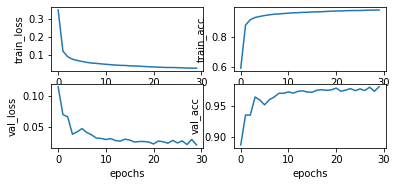

Best acc on val: 0.9812708333333333
Best loss on val: 0.02102893845294602
Finished Training


In [71]:
config = {
    "input_out_channel": 128,
    "input_filter": 3,
    "n_hidden_layers": 1,
    "hidden_out_channel": 128,
    "hidden_filter": 3,
    "lr": 0.0002,
    "activation_function": nn.LeakyReLU(),
    "momentum": 0.38,
    "optimizer": 'Adam',
    "dropout_prob": 0.030874
}
model, best_loss, best_acc = train_model(config=config, model='CNN', train_data=train_data, test_data=val_data, num_epochs=30, with_plot_graphs=True, with_early_stop=False)


In [ ]:
PATH = '/content/drive/MyDrive/ML/Assigment2/CNN_Model.pt'
torch.save(model, PATH)

As we can see, both the loss and accuracy values for the train and validation datasets are in plato so we don't need to train this model for more epochs and it achived good accuracy of 96.19% on the validation set. Now lets test it on the test set

In [18]:
testing(model, test_data)

This model achived 0.9803833333333334 accuracy on the testing set


In [16]:
PATH = r'D:\University\Third year\ML\Assignment 2\CNN_Model.pt'
model = torch.load(PATH, map_location=torch.device('cpu'))

In [24]:
print(count_parameters(model))

11515198


In [29]:
print(inferance_testing(model, test_data, 'cpu'))

1.6083474159240723


## Comparing the model of the first task with CNN

- Accuracy:
  - ANN = 34.05%
  - CNN = 98.03%
- Number of parameters: 
  - ANN = 1880094
  - CNN = 11515198
- Speed of inference on CPU
  - ANN = 0.0340723991394043 sec
  - CNN = 1.6083474159240723 sec

### Questions
1. What preprocessing techniques did you use? Why?
    - I converted the images to gray scale to decrease the color complexity of the image as colors will not play any role in detecting which number in the image. 
2. What data augmentation techniques did you use?
    - I used rotation with 30 degrees as if we applied it, it will not change the number in the image but it will increase the variation in the dataset and make the model more flexable. I also used Normalization as it will increase the speed of training and testing the model.
3. Describe the fine-tuning process and how you reached your final CNN model.
- To fine-tune my model, I spacified some hyperparamters and trained the model with 10 sample drawn from the given prameter space and evaluated it on the validation set. The hyperparmters that I tried to tune were:

      - "input_out_channel": the channel size of the output of the input layer 
      - "input_filter": The kernal size of the input layer
      - "n_hidden_layers": number of hidden layers in the model
      - "hidden_out_channel": the channel size of the output of the hidden layer  
      - "hidden_filter": kernal size of the hidden layer
      - "lr": learning rate
      - "activation_function": choosing between ReLU and LeakyReLU activation functions
      - "momentum": choosing a the momentum for SGD optimizer
      - "optimizer": choosing between 2 optimizers Adam, and SGD
      - "dropout_prob": specifying the dropout probability for the dropout layer
- After making 10 triels, I reached the conclusion that the best preforming model has the following hyperparamters:

      - "input_out_channel": 128
      - "input_filter": 3
      - "n_hidden_layers": 1
      - "hidden_out_channel": 128
      - "hidden_filter": 3
      - "lr": 0.0002
      - "activation_function": nn.LeakyReLU()
      - "momentum": 0.38
      - "optimizer": 'Adam'
      - "dropout_prob": 0.030874
    - This model gave accuracy of 98% for prediction 3 target values from the test set

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [20]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
df = pd.read_csv('loan_data.csv')
ordinal_data = df['purpose']
ordinal_data = np.array(ordinal_data).reshape(-1, 1)
ordinal = OrdinalEncoder()
df['purpose'] = ordinal.fit_transform(ordinal_data)
df

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,2.0,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,1.0,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,2.0,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,2.0,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,1.0,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,0.0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,2.0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,4.0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
def trainer(X, y, with_scaler, param_grid, model, n_components=2):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    if with_scaler:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    grid_search_clf = GridSearchCV(estimator=model,
                        cv=3, scoring='accuracy',
                        param_grid=param_grid)
    grid_search_clf.fit(x_train, y_train)
    best_params = grid_search_clf.best_params_
    y_pred = grid_search_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, best_params


In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = df.drop('credit.policy', axis=1)
y = df['credit.policy'].values

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [i for i in range(10)],
    "min_samples_leaf": [i for i in range(10,100,10)]
}

clf = DecisionTreeClassifier()
accuracy, best_params = trainer(X, y, with_scaler=True, param_grid=param_grid, model=clf)
print("Best parameters set found on development set:")
print(best_params)
print(f'Accuracy score: {accuracy}')


Best parameters set found on development set:
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 10, 'splitter': 'best'}
Accuracy score: 0.982776617954071


d:\Program Files\anaconda\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
162 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Program Files\anaconda\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Program Files\anaconda\envs\pytorch\lib\site-packages\sklearn\tree\_classes.py", line 969, in fit
    super().fit(
  File "d:\Program Files\anaconda\envs\pytorch\lib\site-packages\sklearn\tree\_classes.py", line 238, in fit
    check_scalar(
  File "d:\Program Files\

In [23]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop('credit.policy', axis=1)
y = df['credit.policy'].values

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [i for i in range(1, 20)],
    "max_features": ["sqrt", "log2", None],
    'n_estimators': [50, 100, 150]
}

clf = RandomForestClassifier()
accuracy, best_params = trainer(X, y, with_scaler=True, param_grid=param_grid, model=clf)
print("Best parameters set found on development set:")
print(best_params)
print(f'Accuracy score: {accuracy}')


Best parameters set found on development set:
{'criterion': 'entropy', 'max_depth': 18, 'max_features': None, 'n_estimators': 100}
Accuracy score: 0.9906054279749478


In [24]:
from sklearn.metrics import confusion_matrix
# load the best 2 models

# decision tree
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=10, splitter='best')
# Random forest
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=19, max_features=None, n_estimators=100)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dt_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)

dt_pred = dt_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)

dt_acc = accuracy_score(dt_pred, y_test)
rf_acc = accuracy_score(rf_pred, y_test)

print(f'Decision tree accuracy: {dt_acc}')
print(f'Random forest accuracy: {rf_acc}')

print(f'Decision tree confusion matrix:\n {confusion_matrix(y_pred=dt_pred, y_true=y_test)}')
print(f'Random forest accuracy:\n {confusion_matrix(y_pred=rf_pred, y_true=y_test)}')



Decision tree accuracy: 0.982776617954071
Random forest accuracy: 0.9932150313152401
Decision tree confusion matrix:
 [[ 374   18]
 [  15 1509]]
Random forest accuracy:
 [[ 381   11]
 [   2 1522]]


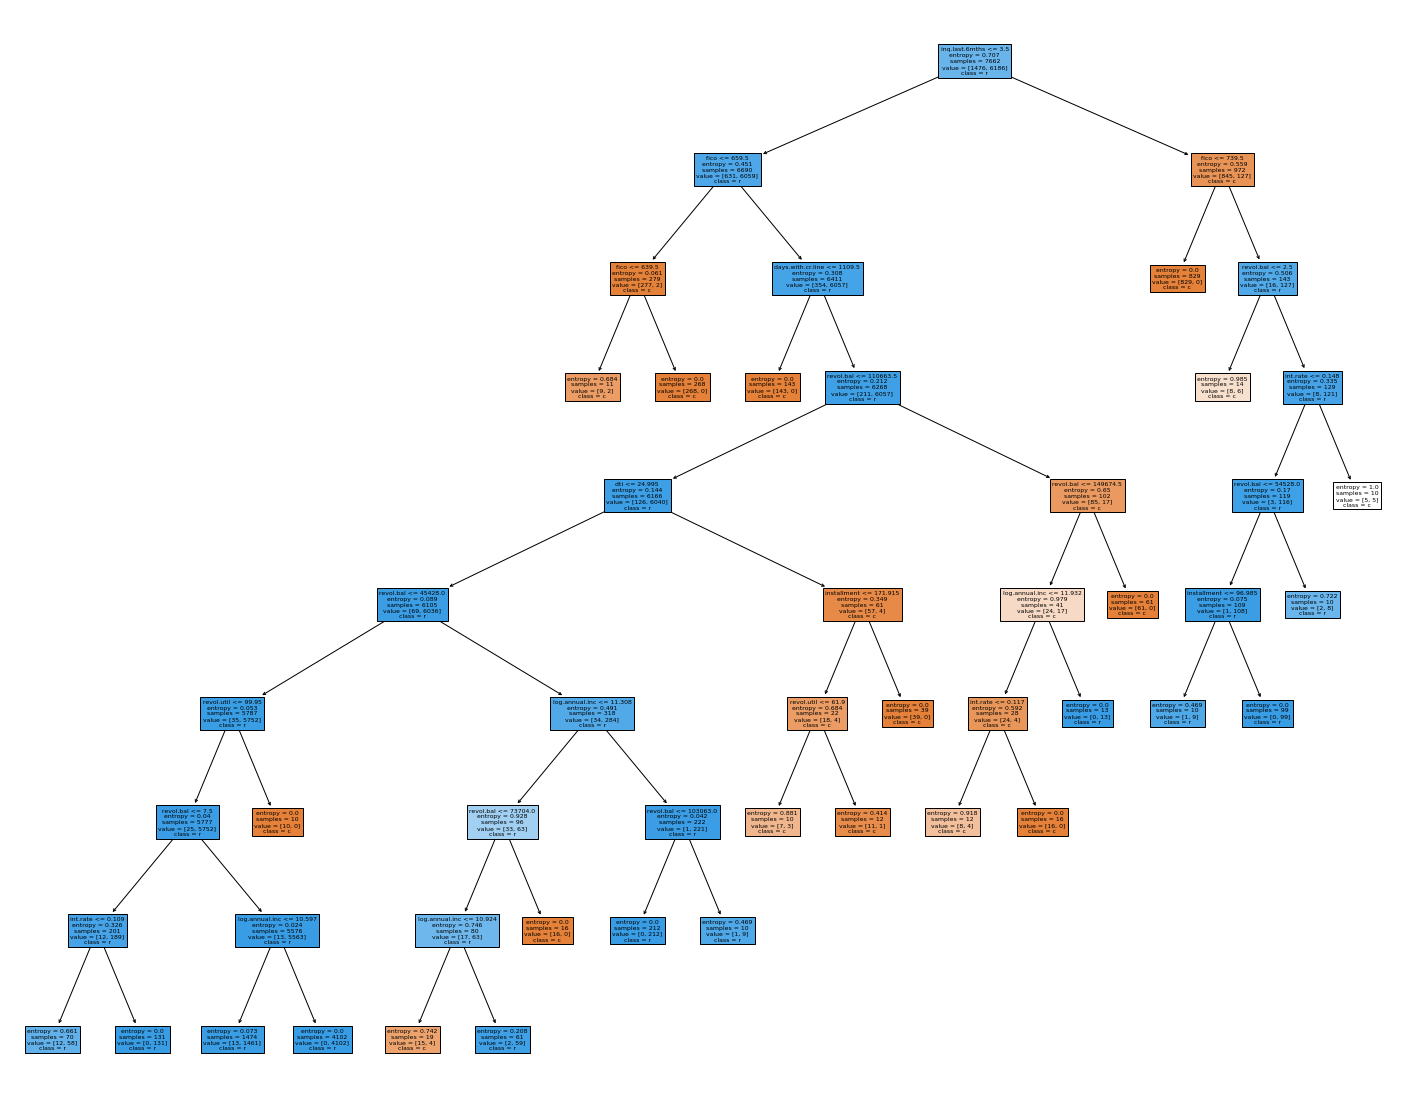

In [26]:
from matplotlib import pyplot as plt
from sklearn import tree
# Visulaization 
text = tree.export_text(dt_clf)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_clf, feature_names=X.columns, class_names='credit.policy',filled=True)

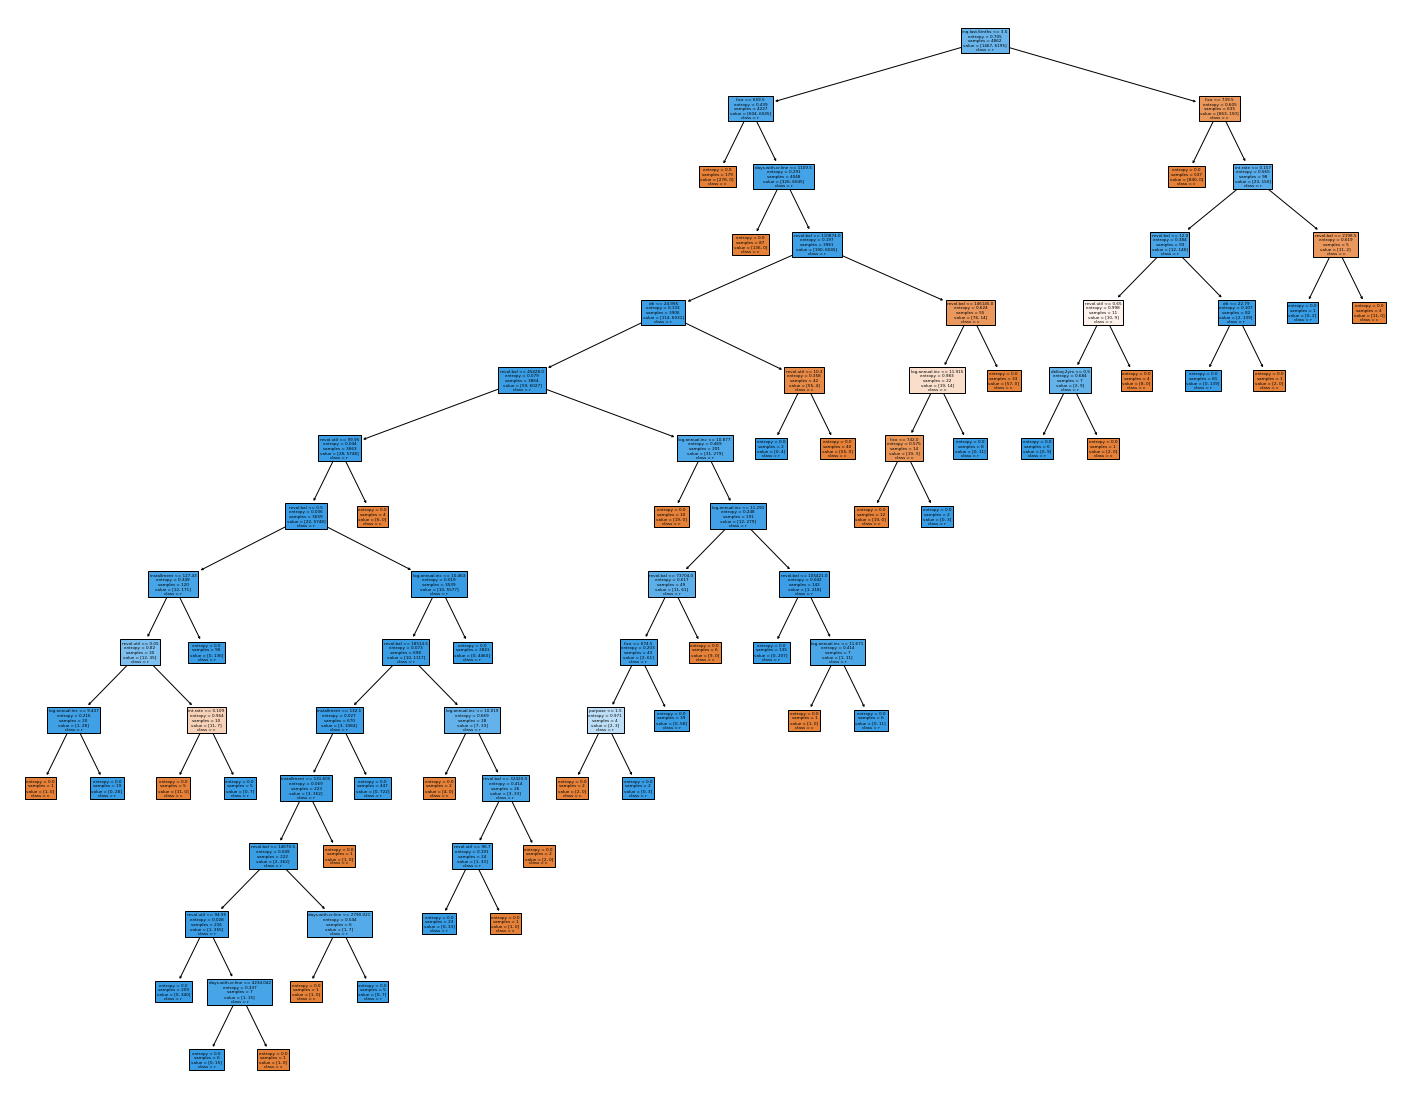

In [27]:
# one of the trees from RF
a_tree = rf_clf.estimators_[5]
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(a_tree, feature_names=X.columns, class_names='credit.policy',filled=True)

### Questions
1. How did the DT compare to the RF in performance? Why?
    - Both of them scored high results of +99% accuracy. However, RF was slightly better because:
        - RF leverages the power of multiple decision trees.
        - RF chooses features randomly during the training process, therefore it doesn't depend highly on a specific set of features
        - RF can generalize the data in a better way
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - Max depth of the RF is higher than DT that's because RF uses the bagging technique in which trees are fitted on bootstrab samples. This allows each tree to have low variance and the RF would still be able to generalize over the dataset
3. What is ensemble learning? What are its pros and cons?
    - Ensemble learning is to combine the power of multiple models in a single model while overcoming their weaknesses, this will allow to reduce the variance and/or bias of the model so it will nethear underfit nor overfit the data. 
    - Pros:
        - Reduce baise and/or variance
        - Better accuracy than a single model
        - More stable and generalization
    - Cons
        - Computationally expensive
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?

Types of boosting:

    - Adaptive boosting: it starts with equal weights to all the datasets. After passing the data to every model, it updates the weights by increasing the weights of the ones that were misclassified.
    - Gradient boosting: the key idea of gradient boosting is that when we combine the best possible next model with previous models, this will minimize the overall prediction error.

Types of bagging:

    - Bagging meta-estimator fits classifiers on random subsets of the original dataset and then aggregates their individual predictions to form a final prediction

    -Random forest: similar to bagging meta as it works by dividing the data into subsets and only small features decide how to split. Then using majority voting from all the DTs, it will decide the prediction

- RF is a bagging method because it divides the dataset and uses DTs and aggregates their results. 

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [27]:
class SVHNDataset(Dataset):
  def __init__(self, images_dir, transform=None):
    self.images_dir = images_dir
    self.transform = transform
    self.X = []
    self.y = []
    for img_path in os.listdir(f'{self.images_dir}'):
      image = cv2.imread(f'{self.images_dir}/{img_path}')
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      t = transforms.ToTensor()
      image = t(image)
      t = transforms.Resize((84,84))
      image = t(image)
      self.X.append(image)
      self.y.append(img_path)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]

    if self.transform:
      image = self.transform(image)
    return image, label


In [29]:
# TODO: Implement task 4
svhn_path = r"/content/drive/MyDrive/ML/Assigment2/svhn"

svhn_dataset = SVHNDataset(svhn_path)


460.png


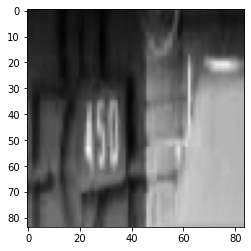

In [30]:
img = svhn_dataset[0][0]
print(svhn_dataset[0][1])
plt.imshow(img[0], cmap='gray')

In [34]:
def testing(model, test_data):
  test_loader = DataLoader(test_data, batch_size=100, shuffle=True)
  with torch.no_grad():
    model.eval()
    running_corrects = 0
    for (x, y) in test_loader:
        x = x.to('cuda')
        y = from_str_to_tensor(y)
        y = y.to('cuda')
        x = x.float()
        pred = model(x)
        for i in range(3):
            _, preds = torch.max(pred[i], 1)
            running_corrects += torch.sum(preds == y[:, i])
    acc = running_corrects.double() / (len(test_data)*3)
    print(f'This model achived {acc} accuracy on the testing set')

In [35]:
testing(model, svhn_dataset)

This model achived 0.08695652173913043 accuracy on the testing set


### Questions
1. How did your model perform? Why is it better/worse?
    - Worse, because the train dataset distribution is different than this SVHN dataset.
2. What is the domain gap in the context of ML?
    - Domain gap is when we have different data representation for the same thing for example, in our case, the mnist contains numbers and SVHN contain numbers but the representation of the number in both of them is different thus the domain is different.
3. Suggest two ways through which the problem of the domain gap can be tackled.
    - we can increase the variation in our train set by adding to it data from different domains
    - We can translate the image to make it look like the data we trained on

## References: 

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#:~:text=A%20Bagging%20classifier%20is%20an,to%20form%20a%20final%20prediction.
- https://scikit-learn.org/stable/modules/ensemble.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
- Lab 7, 9
